In [30]:
from torch_geometric.nn import GCNConv
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import numpy as np
import torch
import ot
from torch_geometric.data import Data
import matplotlib.pyplot as plt

In [32]:
from nilearn import datasets

abide = datasets.fetch_abide_pcp(
    data_dir="/Users/balazsmorvay/Downloads/nilearn_data",
    derivatives="rois_cc200",
    pipeline="cpac",
    band_pass_filtering=True,
    global_signal_regression=True,
    quality_checked=True,
)

[fetch_abide_pcp] Dataset found in /Users/balazsmorvay/Downloads/nilearn_data/ABIDE_pcp


In [33]:
def corr_fisher_z(X):  # X: (T, N) ROI time-series
    C = np.corrcoef(X, rowvar=False)          # (N, N)
    C = np.clip(C, -0.999999, 0.999999)
    Z = np.arctanh(C)                         # Fisher z
    np.fill_diagonal(Z, 0.0)
    return Z

def make_node_features(Z, mode='corr_row'):
    """
    'corr_row' -> node i feature = i-th row of Z (NeuroGraph style)
    'none'     -> no explicit node features (ones)
    """
    N = Z.shape[0]
    if mode == 'corr_row':
        X = Z.copy()
        np.fill_diagonal(X, 0.0)
        return X
    return np.ones((N, 1), dtype=float)

def to_pyg(A, X, y=None, meta=None):
    if Data is None:
        return dict(edge_index=None, edge_weight=None, x=X, y=y, meta=meta)
    # build edge_index/weight from upper triangle
    i, j = np.where(np.triu(A, 1) > 0)
    w = A[i, j]
    # make undirected (i<->j)
    ei = np.vstack([np.hstack([i, j]), np.hstack([j, i])])
    ew = np.hstack([w, w]).astype(np.float32)
    x = torch.tensor(X, dtype=torch.float32)
    data = Data(x=x, # Node features
                edge_index=torch.tensor(ei, dtype=torch.long),
                edge_weight=torch.tensor(ew),
                y=None if y is None else torch.tensor([y], dtype=torch.long))
    data.meta = meta
    return data

In [34]:
graphs = []
normalized_node_features = []
for i, ts in enumerate(abide.rois_cc200):
    pheno = abide.phenotypic.iloc[i]
    # 3.1 connectivity (Fisher-z of Pearson corr)
    Z = corr_fisher_z(ts)
    # 3.2 sparsify like NeuroGraph (e.g., top 10% positive edges)
    # A = top_p_sparsify(Z, p=0.10, keep_positive=True)
    # 3.3 node features (corr row vectors)
    X = make_node_features(Z, mode='corr_row')

    # Similarity matrix -> Distance matrix
    max_dist = np.nanmax(X)
    X = max_dist - X
    np.fill_diagonal(X, 0.0)
    if np.isnan(X.max()):
        X[np.isnan(X)] = max_dist * 1.01
        print(f"nan in {i}")


    normalized_node_features.append(X)
    # 3.4 label: ASD(1)/HC(2) in ABIDE PCP; convert to 0/1
    dx = pheno.get('DX_GROUP')
    y = None if dx is None else int(dx == 1)  # 1=ASD -> 1, 2=HC -> 0
    # 3.5 site/domain
    site = pheno.get('SITE_ID', pheno.get('SITE_NAME', 'NA'))
    graphs.append(to_pyg(Z, X, y=y, meta={'site': site, 'age': pheno.get('AGE_AT_SCAN')}))

print(f'Built {len(graphs)} graphs (static). Example meta:', graphs[0].meta if graphs else None)

/Users/balazsmorvay/PycharmProjects/NeuroGraph/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/balazsmorvay/PycharmProjects/NeuroGraph/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


nan in 36
nan in 105
nan in 113
nan in 125
nan in 149
nan in 150
nan in 392
nan in 394
nan in 401
nan in 589
nan in 641
nan in 830
nan in 832
nan in 838
nan in 845
Built 871 graphs (static). Example meta: {'site': 'PITT', 'age': np.float64(24.45)}


In [35]:
len(graphs), graphs[33].x.max()

(871, tensor(2.2985))

In [36]:
nyu_sites = {'NYU'}
um_sites = {'UM_1', 'UM_2'}
usm_sites = {'USM'}
ucla_sites = {'UCLA_1', 'UCLA_2'}
leuven_sites = {'LEUVEN_1', 'LEUVEN_2'}

nyu_graphs = []
um_graphs = []
usm_graphs = []
ucla_graphs = []
leuven_graphs = []

for graph in graphs:
    site = graph.meta.get('site')
    if site in nyu_sites:
        nyu_graphs.append(graph)
    elif site in um_sites:
        um_graphs.append(graph)
    elif site in usm_sites:
        usm_graphs.append(graph)
    elif site in ucla_sites:
        ucla_graphs.append(graph)
    elif site in leuven_sites:
        leuven_graphs.append(graph)

# (Optional) Print the number of graphs in each new list to verify
print(f"Graphs from NYU: {len(nyu_graphs)}")
print(f"Graphs from UM_1 & UM_2: {len(um_graphs)}")
print(f"Graphs from USM: {len(usm_graphs)}")
print(f"Graphs from UCLA_1 & UCLA_2: {len(ucla_graphs)}")
print(f"Graphs from Leuven_1 & Leuven_2: {len(leuven_graphs)}")

Graphs from NYU: 172
Graphs from UM_1 & UM_2: 120
Graphs from USM: 67
Graphs from UCLA_1 & UCLA_2: 85
Graphs from Leuven_1 & Leuven_2: 56


# Adaptation

In [37]:
Xs = leuven_graphs
Xt = usm_graphs

In [38]:
def fgw(data_s, data_t, C1, C2, M, alpha=0.5, loss_fun='square_loss', device='cpu'):
    p  = torch.ones(data_s.num_nodes, device=device) / data_s.num_nodes
    q  = torch.ones(data_t.num_nodes, device=device) / data_t.num_nodes

    # POT expects numpy arrays
    # returns coupling T and log; objective = alpha*GW + (1-alpha)*OT(feature)
    gw = ot.gromov.fused_gromov_wasserstein2(
        M, C1, C2, p, q, loss_fun=loss_fun, alpha=alpha, log=False, verbose=False, tol_abs=1e-1, max_iter=2
    )

    return gw

In [39]:
source_costs = []
target_costs = []

for i in range(len(Xs)):
    source_costs.append(Xs[i].x) # structural cost is the correlation distance mtx

for j in range(len(Xt)):
    target_costs.append(Xt[j].x)

In [40]:
def feature_cost_M(Xs, Xt, dtype, device):
    return torch.cdist(Xs.x, Xt.x, p=2).to(dtype=dtype, device=device)

In [41]:
device_ = 'cpu'
dtype_ = torch.float32

In [42]:
cost_mtx = np.zeros((len(Xs), len(Xt)))

for i in range(len(Xs)):
    print(i, '/', len(Xs))
    for j in range(len(Xt)):
        M = feature_cost_M(Xs[i], Xt[j], dtype=dtype_, device=device_)
        fgw_dist = fgw(Xs[i],
                        Xt[j],
                        torch.tensor(source_costs[i], device=device_, dtype=dtype_),
                        torch.tensor(target_costs[j], device=device_, dtype=dtype_),
                        M,
                        alpha=0.5,
                        loss_fun='square_loss',
                        device=device_)
        cost_mtx[i, j] = fgw_dist

0 / 56


/var/folders/z_/7fqm4zqs11zdv7cm41c6w_pc0000gn/T/ipykernel_83361/1920267926.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(source_costs[i], device=device_, dtype=dtype_),
/var/folders/z_/7fqm4zqs11zdv7cm41c6w_pc0000gn/T/ipykernel_83361/1920267926.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(target_costs[j], device=device_, dtype=dtype_),


1 / 56
2 / 56
3 / 56
4 / 56
5 / 56
6 / 56
7 / 56
8 / 56
9 / 56
10 / 56
11 / 56
12 / 56
13 / 56
14 / 56
15 / 56
16 / 56
17 / 56
18 / 56
19 / 56
20 / 56
21 / 56
22 / 56
23 / 56
24 / 56
25 / 56
26 / 56
27 / 56
28 / 56
29 / 56
30 / 56
31 / 56
32 / 56
33 / 56
34 / 56
35 / 56
36 / 56
37 / 56
38 / 56
39 / 56
40 / 56
41 / 56
42 / 56
43 / 56
44 / 56
45 / 56
46 / 56
47 / 56
48 / 56
49 / 56
50 / 56
51 / 56
52 / 56
53 / 56
54 / 56
55 / 56


In [43]:
cost_mtx[0, 0], np.min(cost_mtx), np.max(cost_mtx)

(np.float64(2.823665142059326),
 np.float64(1.645031213760376),
 np.float64(10.269405364990234))

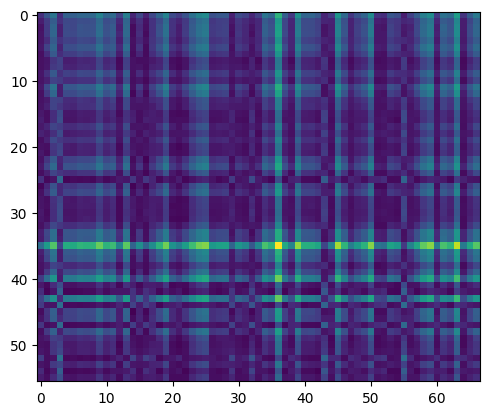

In [44]:
plt.imshow(cost_mtx)

In [45]:
P = ot.emd(a=np.ones(len(Xs)) / len(Xs),
           b=np.ones(len(Xt)) / len(Xt),
           M=cost_mtx,
           numItermax=100000)

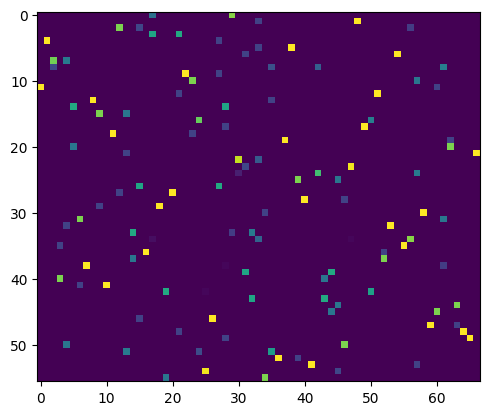

In [46]:
import matplotlib.pyplot as plt

plt.imshow(P)

In [47]:
def keep_top_n(x, n):
    vals, idx = torch.topk(x.view(-1), n)
    mask = torch.zeros_like(x, dtype=torch.bool).view(-1)
    mask[idx] = True
    mask = mask.view_as(x)
    return x * mask

def keep_top_percent(x, k_percent):
    k = int(x.numel() * k_percent / 100.0)
    return keep_top_n(x, k)

In [48]:
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data

transp_Xs = []

for i in range(len(Xs)):
    indices = list(np.nonzero(P[i])[0])
    lambdas = P[i, indices].astype(np.float64)
    lambdas = lambdas / lambdas.sum()

    Ys = [torch.as_tensor(Xt[idx].x, dtype=torch.float) for idx in indices] # nodes*features x 1
    Cs = [torch.as_tensor(target_costs[idx], dtype=torch.float) for idx in indices] # nodes x nodes

    # Barycenter features, structure
    X, C, log = ot.gromov.fgw_barycenters(N=Xs[i].num_nodes,
                                         Ys=Ys, # feature mtx
                                         Cs=Cs, # cost mtx
                                         ps=None,
                                         p=None,
                                         lambdas=lambdas,
                                         loss_fun='square_loss',
                                         symmetric=True,
                                         alpha=0.5,
                                         max_iter=1000,
                                         tol=1e-5,
                                         log=True,
                                         verbose=True)

    # C_sparse = keep_top_n(C, n=M0[i].num_edges)
    C_sparse = keep_top_percent(C, k_percent=50)
    edge_index, edge_attr = dense_to_sparse(C_sparse)
    pyg_graph = Data(x=X, edge_index=edge_index, edge_attr=edge_attr)
    pyg_graph.y = Xs[i].y.item()

    transp_Xs.append(pyg_graph)
    print(f"Done {i}/{len(Xs)}")

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.474273e+02|0.000000e+00|0.000000e+00
    1|2.471753e+02|1.019670e-03|2.520372e-01
    2|2.470123e+02|6.597188e-04|1.629587e-01
    3|2.469159e+02|3.904632e-04|9.641157e-02
    4|2.468231e+02|3.759793e-04|9.280036e-02
    5|2.467636e+02|2.411780e-04|5.951395e-02
    6|2.467363e+02|1.104287e-04|2.724677e-02
    7|2.467145e+02|8.853361e-05|2.184252e-02
    8|2.466949e+02|7.929037e-05|1.956053e-02
    9|2.466883e+02|2.704987e-05|6.672886e-03
   10|2.466858e+02|9.955546e-06|2.455892e-03
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.022956e+02|0.000000e+00|0.000000e+00
    1|3.021541e+02|4.680438e-04|1.414214e-01
    2|3.018154e+02|1.122180e-03|3.386914e-01
    3|3.016983e+02|3.883154e-04|1.171541e-01
    4|3.016659e+02|1.073856e-04|3.239456e-02
    5|3.016437e+02|7.345155e-05|2.215620e-02
    6|3.016369e+02|2.263977e-05|6.828989e-0

# Create the datasets

In [49]:
transp_Xs

[Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=0),
 Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=0),
 Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=0),
 Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=1),
 Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=0),
 Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=0),
 Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=1),
 Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=1),
 Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=0),
 Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=0),
 Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=1),
 Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=1),
 Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=1),
 Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=1),
 Data(x=[200, 200], edge_index=[2, 20000], edge_

In [50]:
len(transp_Xs), transp_Xs[0], len(Xs), Xs[0]

(56,
 Data(x=[200, 200], edge_index=[2, 20000], edge_attr=[20000], y=0),
 56,
 Data(
   x=[200, 200],
   edge_index=[2, 19304],
   y=[1],
   edge_weight=[19304],
   meta={
     site='LEUVEN_1',
     age=23.0,
   }
 ))

# Classify

In [51]:
y_train = [g.y for g in transp_Xs]
y_test  = [g.y.item() for g in Xt]

In [63]:
import random
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from pathlib import Path
import sys
project_root = Path.cwd()
if not (project_root / 'GNN.py').exists():
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
from GNN import GNN3LayerBinary

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


# Infer input feature dim
# in_channels = 4
in_channels = 200
source_dataset = transp_Xs
# source_dataset = Xs
target_dataset = Xt

# Split source -> train/val
idx = torch.randperm(len(source_dataset))
cut = int(0.8 * len(source_dataset))
train_idx, val_idx = idx[:cut], idx[cut:]

train_loader = DataLoader([source_dataset[i] for i in train_idx], batch_size=64, shuffle=True)
val_loader = DataLoader([source_dataset[i] for i in val_idx], batch_size=128, shuffle=False)
tgt_loader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model/optim/loss
model = GNN3LayerBinary(in_channels=in_channels, hidden=128, conv_type='gcn', dropout=0.5, use_batchnorm=True).to('cpu')
opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4)
crit = torch.nn.BCEWithLogitsLoss()


def _run_epoch(loader, train=False):
    if train:
        model.train()
    else:
        model.eval()
    total_loss, n = 0.0, 0
    correct = 0
    for data in loader:
        data = data.to('cpu')
        if train:
            opt.zero_grad()
        logits = model(data.x.float(), data.edge_index, data.batch)
        y = data.y.view(-1).float()
        loss = crit(logits, y)
        if train:
            loss.backward()
            opt.step()
        with torch.no_grad():
            pred = (logits.sigmoid() >= 0.5).long()
            correct += int((pred == y.long()).sum())
        total_loss += float(loss.item()) * y.numel()
        n += y.numel()
    acc = correct / max(n, 1)
    return (total_loss / max(n, 1)), acc


# Train
epochs = 40
for ep in range(1, epochs + 1):
    tr_loss, tr_acc = _run_epoch(train_loader, train=True)
    va_loss, va_acc = _run_epoch(val_loader, train=False)
    if ep == 1 or ep % 5 == 0:
        print(f"Epoch {ep:03d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val acc {va_acc:.3f}")

_, tgt_acc = _run_epoch(tgt_loader, train=False)
print(f"Target accuracy: {tgt_acc:.3f}")

_, tr_acc = _run_epoch(train_loader, train=False)
print(f"Train accuracy: {tr_acc:.3f}")

_, val_acc = _run_epoch(val_loader, train=False)
print(f"Validation accuracy: {val_acc:.3f}")

Epoch 001 | train loss 0.6911 acc 0.568 | val acc 0.583
Epoch 005 | train loss 0.6371 acc 0.659 | val acc 0.583
Epoch 010 | train loss 0.6083 acc 0.705 | val acc 0.583
Epoch 015 | train loss 0.5668 acc 0.773 | val acc 0.583
Epoch 020 | train loss 0.5354 acc 0.795 | val acc 0.417
Epoch 025 | train loss 0.4950 acc 0.864 | val acc 0.417
Epoch 030 | train loss 0.4403 acc 0.841 | val acc 0.417
Epoch 035 | train loss 0.3511 acc 1.000 | val acc 0.417
Epoch 040 | train loss 0.3410 acc 0.955 | val acc 0.417
Target accuracy: 0.642
Train accuracy: 0.477
Validation accuracy: 0.417
